# Predicting churn with PySpark

### Overview

Customer churn is when an existing customer, user, subscriber or any kind of return client stops doing business or ends the relationship with a company or service. Not surprisingly, **Churn Rate** is one of the most important KPIs for SaaS companies and is a good measurement of service health. Predicting churn is a fundamental task to help CS teams take action and avoid loss of customers.

### Project Objectives

In this project, we are going to use a big dataset of activity logs generated by users of a fictional music streaming service called Sparkify to train a machine learning model. For that we are going to use PySpark API over Spark engine, which is built to work with large-scale data processing, to perform all necessary steps from data cleaning to model training. By the end we expect to have a trained machine learning model capable of identifying users about to churn.

### Metrics

To measure the performance of our model we are going to use two main metrics: Area under the ROC Curve **(AUC)** and **F1-score**. We picked these metrics instead of accuracy, for example, due to the characteristics of the problem. As the number of users that churn is usually much smaller than the total number of users, just predicting that no user will churn would give us a good accuracy level and this is not useful. AUC is a good metric here because it is scale-invariant. Besides that, for this specific problem a false negative is much more harmful than a false positive, so F1-score helps us to have good precision and recall.

In [1]:
!source activate py36
!pip install httpagentparser

/bin/sh: 1: source: not found


In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import time
import httpagentparser

import matplotlib.pyplot as plt

from math import floor

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, countDistinct, first, last, split, udf, when
from pyspark.sql.functions import sum as f_sum, max as f_max
from pyspark.sql.types import DateType, StringType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, MaxAbsScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [4]:
# Check configuration
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.driver.host', '188bbd62ec48'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '44353'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1593660165911')]

## Data Analysis

Some questions we should try to answer at this initial point are:

* What the data looks like? (Size, dimensions, structure...)
* Are there any abnormalities we need to address?
* Do we need to transform it in some way?

Let's start loading the data and getting some understanding about it's structure.

In [5]:
# Load data
df = spark.read.json('mini_sparkify_event_data.json')

# DataFrame structure
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# DataFrame's shape
(df.count(), len(df.columns))

(286500, 18)

In [7]:
# Data overview
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [8]:
# Checking for duplicate log entries
df.count() - df.dropDuplicates().count()

0

From these first results we have been able to learn that our dataset is formed by activity logs, it has almost 300,000 logs and the main entity here are users' actions and not the users themselves. Since we want to determine churn probability based on users, it seems we will indeed need to perform some transformation.

We need to transform this activity-oriented dataset to a user-oriented dataset that we can use as input to our machine learning algorithm. We'll have to use 'userId' as an identifier, so let's check for further abnormalities and analyze if 'sessionId' could also be used to uniquely identify a user.

In [9]:
# Checking for null values in userId column
df.filter(df.userId.isNull()).count()

0

In [10]:
# Checking for empty values in userId column
df.filter(df.userId == '').count()

8346

In [11]:
# Let's see if we can rely in sessionId to identify user activities when userId is empty
# Checking for null values in sessionId column
df.filter(df.sessionId.isNull()).count()

0

In [12]:
# Checking for empty values in sessionId column
df.filter(df.sessionId == '').count()

0

In [13]:
# Inspecting 'sessionId' and 'userId' relation
df.select(['sessionId', 'userId']).where((df.userId != '') & (df.sessionId < 10)).dropDuplicates().sort('sessionId').show()

+---------+------+
|sessionId|userId|
+---------+------+
|        1|100001|
|        1|     2|
|        1|300001|
|        2|200002|
|        3|300003|
|        3|100003|
|        4|100004|
|        5|     6|
|        5|100005|
|        6|300006|
|        6|100006|
|        7|200007|
|        8|     9|
|        9|    10|
|        9|300009|
|        9|100009|
+---------+------+



As we can see, one 'sessionId' can be related to activites from more than one user, so it can't be used as an identifier. Since we don't know to which user they belong, we have no option other than remove logs without 'userId'.

In [14]:
# Removing logs that doesn't have 'userId'
df = df.filter(df.userId != '')
(df.count(), len(df.columns))

(278154, 18)

The next step is to find out how many users have had their activities logged in our dataset.

In [15]:
# Counting users
df.select('userId').dropDuplicates().count()

225

Another useful piece of information is to know the time window for which the logs were collected. To know that, we need to convert the timestamps in 'ts' to a readable date and time format and then sort accordingly.

In [16]:
# Convert timestamps into datetime format for further analysis
df = df.withColumn('registrationDatetime', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('tsDatetime', (df['ts'] / 1000).cast(TimestampType()))

In [17]:
# Sorting in ascending order to identify the beginning of the records
df.select('ts', 'tsDatetime').sort('ts').show()

+-------------+-------------------+
|           ts|         tsDatetime|
+-------------+-------------------+
|1538352117000|2018-10-01 00:01:57|
|1538352180000|2018-10-01 00:03:00|
|1538352394000|2018-10-01 00:06:34|
|1538352416000|2018-10-01 00:06:56|
|1538352676000|2018-10-01 00:11:16|
|1538352678000|2018-10-01 00:11:18|
|1538352886000|2018-10-01 00:14:46|
|1538352899000|2018-10-01 00:14:59|
|1538352905000|2018-10-01 00:15:05|
|1538353084000|2018-10-01 00:18:04|
|1538353146000|2018-10-01 00:19:06|
|1538353150000|2018-10-01 00:19:10|
|1538353218000|2018-10-01 00:20:18|
|1538353375000|2018-10-01 00:22:55|
|1538353376000|2018-10-01 00:22:56|
|1538353441000|2018-10-01 00:24:01|
|1538353576000|2018-10-01 00:26:16|
|1538353668000|2018-10-01 00:27:48|
|1538353687000|2018-10-01 00:28:07|
|1538353744000|2018-10-01 00:29:04|
+-------------+-------------------+
only showing top 20 rows



In [18]:
# Identifying the end of the recording
df.select('ts', 'tsDatetime').sort('ts', ascending=False).show()

+-------------+-------------------+
|           ts|         tsDatetime|
+-------------+-------------------+
|1543799476000|2018-12-03 01:11:16|
|1543622579000|2018-12-01 00:02:59|
|1543622432000|2018-12-01 00:00:32|
|1543622411000|2018-12-01 00:00:11|
|1543622398000|2018-11-30 23:59:58|
|1543622395000|2018-11-30 23:59:55|
|1543622365000|2018-11-30 23:59:25|
|1543622355000|2018-11-30 23:59:15|
|1543622320000|2018-11-30 23:58:40|
|1543622287000|2018-11-30 23:58:07|
|1543622282000|2018-11-30 23:58:02|
|1543622248000|2018-11-30 23:57:28|
|1543622193000|2018-11-30 23:56:33|
|1543622173000|2018-11-30 23:56:13|
|1543622164000|2018-11-30 23:56:04|
|1543622122000|2018-11-30 23:55:22|
|1543622121000|2018-11-30 23:55:21|
|1543622093000|2018-11-30 23:54:53|
|1543622086000|2018-11-30 23:54:46|
|1543622052000|2018-11-30 23:54:12|
+-------------+-------------------+
only showing top 20 rows



It's reasonable to assume that the recordings started on 1st of October 2018 and stopped just before 1st of December 2012. There are very few outliers and we will just remove them.

In [19]:
# Default observation start and end
default_start_ts = 1538352000000 # 2018-10-01 00:00:00
default_end_ts = 1543622400000 # 2018-12-01 00:00:00

df = df.filter(df.ts < default_end_ts)
(df.count(), len(df.columns))

(278150, 20)

As our next step, we are going to take a look at our categorical features. But before that, let's see if we can transform 'location' and 'userAgent' into something more useful. The way they are at the moment we can't use them as categorical features in our model. Let's try to extract the State from 'location' and the operational system and browser from 'userAgent' and check how much categories we get from those.

In [20]:
df = df.withColumn('locationState', split(col('location'), ', ').getItem(1))

extract_os_udf = udf(lambda s: httpagentparser.detect(s).get('os', dict()).get('name', None) if s is not None else None, StringType())
extract_browser_udf = udf(lambda s: httpagentparser.detect(s).get('browser', dict()).get('name', None) if s is not None else None, StringType())

df = df.withColumn('os', extract_os_udf(col('userAgent')))
df = df.withColumn('browser', extract_browser_udf(col('userAgent')))

In [21]:
# Exploring possible values of main categorical features
df_pd = df.toPandas()

In [22]:
df_pd.auth.unique(), df_pd.gender.unique(), df_pd.level.unique(), df_pd.locationState.unique(), df_pd.method.unique(), df_pd.page.unique(), df_pd.status.unique(), df_pd.os.unique(), df_pd.browser.unique()

(array(['Logged In', 'Cancelled'], dtype=object),
 array(['M', 'F'], dtype=object),
 array(['paid', 'free'], dtype=object),
 array(['CA', 'MA-NH', 'FL', 'WA', 'MD', 'CO', 'TX', 'GA-AL', 'AZ',
        'NY-NJ-PA', 'PA-NJ-DE-MD', 'GA', 'IL-MO', 'OH', 'TN-VA', 'SC-NC',
        'WV', 'MN-WI', 'OK', 'CT', 'KY', 'VA-NC', 'KY-IN', 'NJ', 'UT',
        'PA-NJ', 'NE-IA', 'NC-SC', 'NH', 'MS', 'VA', 'PA', 'AL',
        'DC-VA-MD-WV', 'IL-IN-WI', 'MI', 'MO-KS', 'NY', 'IN', 'NV', 'MT',
        'WI', 'NC', 'IA', 'TN-MS-AR', 'AK', 'RI-MA', 'IL', 'MO-IL',
        'OH-KY-IN', 'LA', 'OR', 'AR', 'SC', 'MD-WV', 'UT-ID', 'OR-WA', 'TN'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),
 array(

The main goal of this project is to predict churn, but first we need to identify when a user has churned. How could we do that with the features we have? From the above results, 'auth' seems to be promising, so let's explore it further.

In [23]:
# Exploring 'auth' distribution
df.groupby('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278098|
+---------+------+



In [24]:
# Listing all logs with 'auth'='Cancelled'
df.select(['userId', 'auth', 'tsDatetime']).where(df.auth == 'Cancelled').sort('tsDatetime').show(52)

+------+---------+-------------------+
|userId|     auth|         tsDatetime|
+------+---------+-------------------+
|100011|Cancelled|2018-10-01 18:04:45|
|100001|Cancelled|2018-10-02 16:36:45|
|100024|Cancelled|2018-10-04 23:17:18|
|300007|Cancelled|2018-10-05 02:08:58|
|100006|Cancelled|2018-10-05 15:24:30|
|    18|Cancelled|2018-10-07 20:26:30|
|100019|Cancelled|2018-10-07 22:57:51|
|    32|Cancelled|2018-10-08 21:10:46|
|100003|Cancelled|2018-10-11 16:19:41|
|   125|Cancelled|2018-10-12 04:35:18|
|   105|Cancelled|2018-10-12 20:17:21|
|    17|Cancelled|2018-10-13 21:19:44|
|100023|Cancelled|2018-10-14 00:00:37|
|   143|Cancelled|2018-10-15 07:34:14|
|200001|Cancelled|2018-10-15 18:55:20|
|   101|Cancelled|2018-10-16 22:30:37|
|   129|Cancelled|2018-10-17 00:29:21|
|   121|Cancelled|2018-10-17 07:02:29|
|    51|Cancelled|2018-10-17 07:39:32|
|100005|Cancelled|2018-10-19 17:57:05|
|    87|Cancelled|2018-10-20 15:49:16|
|   122|Cancelled|2018-10-20 19:01:08|
|100017|Cancelled|2018-10

In [25]:
# Tracking down all activities from the first user to have 'auth'='Cancelled'
df.where(df.userId == '100011').select(['userId','itemInSession','auth','level','page','tsDatetime']).show(100)

+------+-------------+---------+-----+--------------------+-------------------+
|userId|itemInSession|     auth|level|                page|         tsDatetime|
+------+-------------+---------+-----+--------------------+-------------------+
|100011|            0|Logged In| free|                Home|2018-10-01 17:20:22|
|100011|            1|Logged In| free|            NextSong|2018-10-01 17:20:56|
|100011|            2|Logged In| free|                Home|2018-10-01 17:21:03|
|100011|            3|Logged In| free|            NextSong|2018-10-01 17:27:47|
|100011|            4|Logged In| free|         Roll Advert|2018-10-01 17:27:47|
|100011|            5|Logged In| free|            NextSong|2018-10-01 17:30:56|
|100011|            6|Logged In| free|                Home|2018-10-01 17:31:44|
|100011|            7|Logged In| free|            NextSong|2018-10-01 17:34:45|
|100011|            8|Logged In| free|            NextSong|2018-10-01 17:39:17|
|100011|            9|Logged In| free|  

Great! It looks like 'auth' is equal to 'Cancelled' at the last log when a user churns. We'll be able to use it to create the target label for our classifier. More than that, we now know that from the 225 total users, 52 churned and 173 don't. This proves right our initial guess of a imbalanced dataset.

Next, based on the way web services work, we may make another guess that features 'page', 'method' and 'status' are probably correlated. Method and status probably refer to the HTTP access to a web page, which is probably tightly related to 'page' feature.

In [26]:
# Exploring 'auth', 'method', 'status' and 'page' correlation
df.select(['auth', 'method', 'status', 'page']).dropDuplicates().sort(['auth', 'method', 'status']).show()

+---------+------+------+--------------------+
|     auth|method|status|                page|
+---------+------+------+--------------------+
|Cancelled|   GET|   200|Cancellation Conf...|
|Logged In|   GET|   200|               About|
|Logged In|   GET|   200|                Home|
|Logged In|   GET|   200|            Settings|
|Logged In|   GET|   200|         Roll Advert|
|Logged In|   GET|   200|                Help|
|Logged In|   GET|   200|           Downgrade|
|Logged In|   GET|   200|             Upgrade|
|Logged In|   GET|   404|               Error|
|Logged In|   PUT|   200|     Add to Playlist|
|Logged In|   PUT|   200|            NextSong|
|Logged In|   PUT|   307|       Save Settings|
|Logged In|   PUT|   307|              Logout|
|Logged In|   PUT|   307|          Add Friend|
|Logged In|   PUT|   307|      Submit Upgrade|
|Logged In|   PUT|   307|              Cancel|
|Logged In|   PUT|   307|           Thumbs Up|
|Logged In|   PUT|   307|         Thumbs Down|
|Logged In|  

Those are all possible combinations of the four features ('auth', 'method', 'status', 'page') and luckly they are not as many as they could be. Each 'page' value maps to only one value of 'auth', 'method' and 'status', so we only need to keep 'page' as a feature to our model (although we are going to use 'auth' to create our label, we could just use 'page'='Cancellation Confirmation' for that too).

To finish this first analysis on 'page', let's check how it is distributed:

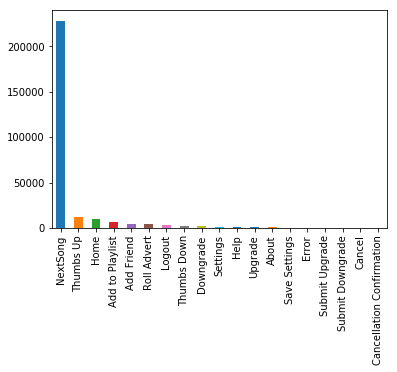

In [27]:
# Distrbution for 'page'
df_pd['page'].value_counts().plot('bar');

As we can see, page distribution is highly imbalanced. 'Next Song' represents roughly 90% of all 'page' logs. We need to keep this in mind when we are going to perform further feature engineering.

Back to the features we've transformed earlier, we should decide if it makes sense to keep them as input. First of all, it seems that there are a lot of possible values for 'locationState', let's see how many they are and how they are distributed over the activities log dataset.

In [28]:
# Number of possible values for 'locationState'
len(df_pd.locationState.unique())

58

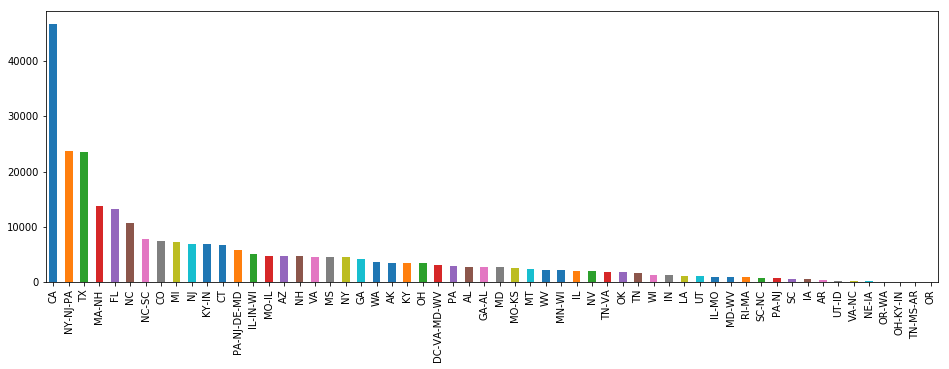

In [29]:
# Distrbution for 'locationState'
plt.figure(figsize=(16,5))
df_pd['locationState'].value_counts().plot('bar');

There are more possible values for 'locationState' than users who churned in our dataset. This makes this feature a bad candidate for input to our model, since churned users may be underrepresented by it, so we are going to drop it. Next, let's build more visualizations for the remaining categorical features.

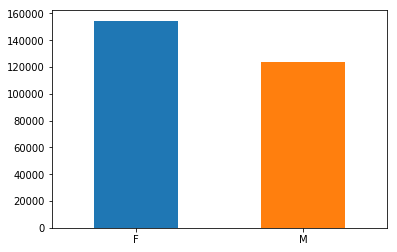

In [30]:
# Distribution for 'gender'
df_pd['gender'].value_counts().plot('bar', rot=0);

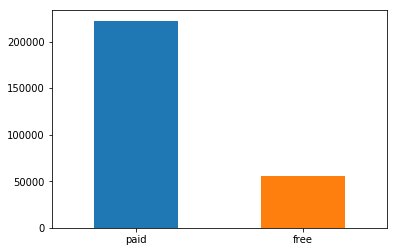

In [31]:
# Distribution for 'level'
df_pd['level'].value_counts().plot('bar', rot=0);

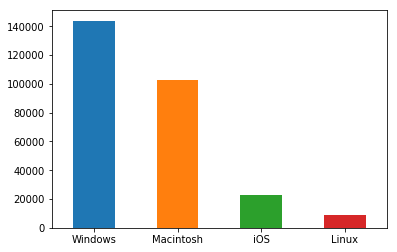

In [32]:
# Distribution for 'os'
df_pd['os'].value_counts().plot('bar', rot=0);

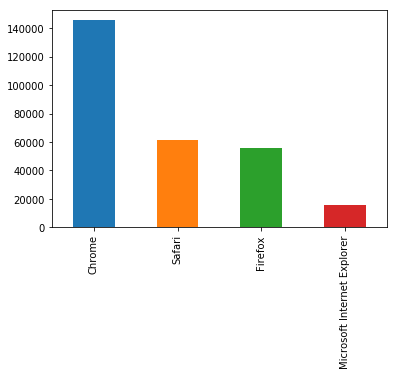

In [33]:
# Distribution for 'browser'
df_pd['browser'].value_counts().plot('bar');

We can see that, except by 'gender', the other categorical features also have skewed distributions, like 'page'. One situation that may me interfere with 'os' and 'browser' is the fact that one user may use more than one different device or browser to use the streaming service, so let's check if this is happening.

In [34]:
# checking the combinations of 'userId' and 'os'/'browser'
user_count = df.select('userId').dropDuplicates().count()
userId_os_count = df.select(['userId', 'os']).dropDuplicates().count()
userId_browser_count = df.select(['userId', 'browser']).dropDuplicates().count()

user_count, userId_os_count, userId_browser_count

(225, 225, 225)

The good news is that our users seem to be very loyal to their OSs and browsers, so we don't need to worry about that, we can pick the value of any row for those features.

Lastly, the same way we have users who churned in the middle of the observation window, we may also have new users during this period. The following command will tell us how many they are.

In [35]:
df.select(['userId','registrationDatetime']).where(df.registration > default_start_ts).dropDuplicates().count()

5

At the end of the analysis step, we were able to gather some insights about the data:

* the whole dataset has no duplicate logs
* 'sessionId' can't be used to identify unique user activity
* there are logs from 225 users in the dataset, 52 of them churned during the observation window
* the observation window starts on 1st of October 2018 and ends just before 1st of December 2018 (2 months)
* 'Cancelled' authentication level maps to 'Cancellation Confirmation' page and are the last logs of users that churned
* 'method' and 'status' map to 'page' values, i.e. are dependent variables
* during the whole period users sticked to the same OSs (Windows, macOS, iOS or Linux) and browsers (IE, Safari, Chrome or Firefox) to access the streaming service
* most of the categorical features and the target label have imbalanced distributions

## Data Preprocessing



In [36]:
userId_window_by_ts = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# later registration timestamp
df = df.withColumn('firstLogTs', first(col('ts')).over(userId_window_by_ts))
df = df.withColumn('observationStart', when(df.registration > default_start_ts, df.firstLogTs).otherwise(default_start_ts))

# churned users last log timestamp
df = df.withColumn('lastAuth', last(col('auth')).over(userId_window_by_ts))
df = df.withColumn('lastLogTs', last(col('ts')).over(userId_window_by_ts))
df = df.withColumn('observationEnd', when(df.lastAuth == 'Cancelled', df.lastLogTs).otherwise(default_end_ts))

# auxiliary calculated columns
one_day_ms = 24*60*60*1000
df = df.withColumn('observationWindowTotalDays', (col('observationEnd') - col('observationStart'))/one_day_ms)
df = df.withColumn('observationWindowHalfTs', (col('observationEnd') - col('observationStart'))/2 + col('observationStart'))

# user last subscription level
df = df.withColumn('lastSubscriptionLevel', last(col('level')).over(userId_window_by_ts))

In [37]:
df.select(['userId', 'lastAuth']).dropDuplicates().show()

+------+---------+
|userId| lastAuth|
+------+---------+
|100010|Logged In|
|200002|Logged In|
|   125|Cancelled|
|   124|Logged In|
|    51|Cancelled|
|     7|Logged In|
|    15|Logged In|
|    54|Cancelled|
|   155|Logged In|
|100014|Cancelled|
|   132|Logged In|
|   154|Logged In|
|   101|Cancelled|
|    11|Logged In|
|   138|Logged In|
|300017|Logged In|
|100021|Cancelled|
|    29|Cancelled|
|    69|Logged In|
|   112|Logged In|
+------+---------+
only showing top 20 rows



In [38]:
# Aggregation by userId
user_df = df.groupby('userId').agg(
    first(when(col('lastAuth') == 'Cancelled', 1).otherwise(0)).alias('churned'),
    
    first(when(col('lastSubscriptionLevel') == 'paid', 1).otherwise(0)).alias('lastSubscriptionLevel'),
    first(when(col('gender') == 'M', 1).otherwise(0)).alias('gender'),
    first(col('observationStart')).alias('observationStart'),
    first(col('observationEnd')).alias('observationEnd'),
    first(col('observationWindowTotalDays')).alias('observationWindowTotalDays'),    
    first(when(col('os') == 'Windows', 1).otherwise(0)).alias('windows'),
    first(when(col('os') == 'Macintosh', 1).otherwise(0)).alias('macOS'),
    first(when(col('os') == 'iOS', 1).otherwise(0)).alias('iOS'),
    first(when(col('os') == 'Linux', 1).otherwise(0)).alias('linux'),
    first(when(col('browser') == 'Firefox', 1).otherwise(0)).alias('firefox'),
    first(when(col('browser') == 'Chrome', 1).otherwise(0)).alias('chrome'),
    first(when(col('browser') == 'Safari', 1).otherwise(0)).alias('safari'),
    first(when(col('browser') == 'Microsoft Internet Explorer', 1).otherwise(0)).alias('ie'),
    
    f_sum(when(col('page') == 'NextSong', 1).otherwise(0)).alias('songCount'),
    f_sum(when(col('page') == 'Thumbs Up', 1).otherwise(0)).alias('thumbsUpCount'),
    f_sum(when(col('page') == 'Thumbs Down', 1).otherwise(0)).alias('thumbsDownCount'),
    f_sum(when(col('page') == 'Add Friend', 1).otherwise(0)).alias('addFriendCount'),
    f_sum(when(col('page') == 'Add to Playlist', 1).otherwise(0)).alias('addToPlaylistCount'),
    f_sum(when(col('page') == 'Submit Downgrade', 1).otherwise(0)).alias('downgradeCount'),
    f_sum(when(col('page') == 'Submit Upgrade', 1).otherwise(0)).alias('upgradeCount'),
    f_sum(when(col('page') == 'Home', 1).otherwise(0)).alias('homeCount'),
    f_sum(when(col('page') == 'Roll Advert', 1).otherwise(0)).alias('adCount'),
    f_sum(when(col('page') == 'Help', 1).otherwise(0)).alias('helpCount'),
    f_sum(when(col('page') == 'Settings', 1).otherwise(0)).alias('settingsCount'),
    f_sum(when(col('page') == 'Error', 1).otherwise(0)).alias('errorCount'),
    
    f_sum(when((col('page') == 'NextSong')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('songFirstHalf'),
    f_sum(when((col('page') == 'NextSong') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('songSecondHalf'),
    f_sum(when((col('page') == 'Thumbs Up')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsUpFirstHalf'),
    f_sum(when((col('page') == 'Thumbs Up') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsUpSecondHalf'),
    f_sum(when((col('page') == 'Thumbs Down')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsDownFirstHalf'),
    f_sum(when((col('page') == 'Thumbs Down') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsDownSecondHalf'),
    f_sum(when((col('page') == 'Add Friend')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('addFriendFirstHalf'),
    f_sum(when((col('page') == 'Add Friend') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('addFriendSecondHalf'),
    f_sum(when((col('page') == 'Add to Playlist')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('addToPlaylistFirstHalf'),
    f_sum(when((col('page') == 'Add to Playlist') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('addToPlaylistSecondHalf'),
    f_sum(when((col('page') == 'Home')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('homeFirstHalf'),
    f_sum(when((col('page') == 'Home') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('homeSecondHalf'),
    f_sum(when((col('page') == 'Roll Advert')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('adFirstHalf'),
    f_sum(when((col('page') == 'Roll Advert') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('adSecondHalf'),
    f_sum(when((col('page') == 'Help')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('helpFirstHalf'),
    f_sum(when((col('page') == 'Help') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('helpSecondHalf'),
    f_sum(when((col('page') == 'Settings')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('settingsFirstHalf'),
    f_sum(when((col('page') == 'Settings') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('settingsSecondHalf'),
    f_sum(when((col('page') == 'Error')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('errorFirstHalf'),
    f_sum(when((col('page') == 'Error') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('errorSecondHalf')
)

# new dataframe schema
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churned: integer (nullable = true)
 |-- lastSubscriptionLevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- observationStart: long (nullable = true)
 |-- observationEnd: long (nullable = true)
 |-- observationWindowTotalDays: double (nullable = true)
 |-- windows: integer (nullable = true)
 |-- macOS: integer (nullable = true)
 |-- iOS: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- firefox: integer (nullable = true)
 |-- chrome: integer (nullable = true)
 |-- safari: integer (nullable = true)
 |-- ie: integer (nullable = true)
 |-- songCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- thumbsDownCount: long (nullable = true)
 |-- addFriendCount: long (nullable = true)
 |-- addToPlaylistCount: long (nullable = true)
 |-- downgradeCount: long (nullable = true)
 |-- upgradeCount: long (nullable = true)
 |-- homeCount: long (nullable = true)
 |-- adCount: long (nullabl

In [39]:
user_df = user_df\
.withColumn('songPerDay', col('songCount') / col('observationWindowTotalDays'))\
.withColumn('thumbsUpPerDay', col('thumbsUpCount') / col('observationWindowTotalDays'))\
.withColumn('thumbsDownPerDay', col('thumbsDownCount') / col('observationWindowTotalDays'))\
.withColumn('addFriendPerDay', col('addFriendCount') / col('observationWindowTotalDays'))\
.withColumn('addToPlaylistPerDay', col('addToPlaylistCount') / col('observationWindowTotalDays'))\
.withColumn('downgradePerDay', col('downgradeCount') / col('observationWindowTotalDays'))\
.withColumn('upgradePerDay', col('upgradeCount') / col('observationWindowTotalDays'))\
.withColumn('homePerDay', col('homeCount') / col('observationWindowTotalDays'))\
.withColumn('adPerDay', col('adCount') / col('observationWindowTotalDays'))\
.withColumn('helpPerDay', col('helpCount') / col('observationWindowTotalDays'))\
.withColumn('settingsPerDay', col('settingsCount') / col('observationWindowTotalDays'))\
.withColumn('errorPerDay', col('errorCount') / col('observationWindowTotalDays'))\
.withColumn('songFirstHalfPerDay', col('songFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('songSecondHalfPerDay', col('songSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsUpFirstHalfPerDay', col('thumbsUpFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsUpSecondHalfPerDay', col('thumbsUpSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsDownFirstHalfPerDay', col('thumbsDownFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsDownSecondHalfPerDay', col('thumbsDownSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addFriendFirstHalfPerDay', col('addFriendFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addFriendSecondHalfPerDay', col('addFriendSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addToPlaylistFirstHalfPerDay', col('addToPlaylistFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addToPlaylistSecondHalfPerDay', col('addToPlaylistSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('homeFirstHalfPerDay', col('homeFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('homeSecondHalfPerDay', col('homeSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('adFirstHalfPerDay', col('adFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('adSecondHalfPerDay', col('adSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('helpFirstHalfPerDay', col('helpFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('helpSecondHalfPerDay', col('helpSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('settingsFirstHalfPerDay', col('settingsFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('settingsSecondHalfPerDay', col('settingsSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('errorFirstHalfPerDay', col('errorFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('errorSecondHalfPerDay', col('errorSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('songPerDayTrend', (col('songSecondHalfPerDay') - col('songFirstHalfPerDay')))\
.withColumn('thumbsUpPerDayTrend', (col('thumbsUpSecondHalfPerDay') - col('thumbsUpFirstHalfPerDay')))\
.withColumn('thumbsDownPerDayTrend', (col('thumbsDownSecondHalfPerDay') - col('thumbsDownFirstHalfPerDay')))\
.withColumn('addFriendPerDayTrend', (col('addFriendSecondHalfPerDay') - col('addFriendFirstHalfPerDay')))\
.withColumn('addToPlaylistPerDayTrend', (col('addToPlaylistSecondHalfPerDay') - col('addToPlaylistFirstHalfPerDay')))\
.withColumn('homePerDayTrend', (col('homeSecondHalfPerDay') - col('homeFirstHalfPerDay')))\
.withColumn('adPerDayTrend', (col('adSecondHalfPerDay') - col('adFirstHalfPerDay')))\
.withColumn('helpPerDayTrend', (col('helpSecondHalfPerDay') - col('helpFirstHalfPerDay')))\
.withColumn('settingsPerDayTrend', (col('settingsSecondHalfPerDay') - col('settingsFirstHalfPerDay')))\
.withColumn('errorPerDayTrend', (col('errorSecondHalfPerDay') - col('errorFirstHalfPerDay')))

user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churned: integer (nullable = true)
 |-- lastSubscriptionLevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- observationStart: long (nullable = true)
 |-- observationEnd: long (nullable = true)
 |-- observationWindowTotalDays: double (nullable = true)
 |-- windows: integer (nullable = true)
 |-- macOS: integer (nullable = true)
 |-- iOS: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- firefox: integer (nullable = true)
 |-- chrome: integer (nullable = true)
 |-- safari: integer (nullable = true)
 |-- ie: integer (nullable = true)
 |-- songCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- thumbsDownCount: long (nullable = true)
 |-- addFriendCount: long (nullable = true)
 |-- addToPlaylistCount: long (nullable = true)
 |-- downgradeCount: long (nullable = true)
 |-- upgradeCount: long (nullable = true)
 |-- homeCount: long (nullable = true)
 |-- adCount: long (nullabl

In [40]:
user_df = user_df.drop('observationStart', 'observationEnd', 'observationWindowTotalDays',
                       'songCount', 'songFirstHalf', 'songSecondHalf', 'songFirstHalfPerDay', 'songSecondHalfPerDay',
                       'thumbsUpCount', 'thumbsUpFirstHalf', 'thumbsUpSecondHalf', 'thumbsUpFirstHalfPerDay', 'thumbsUpSecondHalfPerDay',
                       'thumbsDownCount', 'thumbsDownFirstHalf', 'thumbsDownSecondHalf', 'thumbsDownFirstHalfPerDay', 'thumbsDownSecondHalfPerDay',
                       'addFriendCount', 'addFriendFirstHalf', 'addFriendSecondHalf', 'addFriendFirstHalfPerDay', 'addFriendSecondHalfPerDay',
                       'addToPlaylistCount', 'addToPlaylistFirstHalf', 'addToPlaylistSecondHalf', 'addToPlaylistFirstHalfPerDay', 'addToPlaylistSecondHalfPerDay',
                       'downgradeCount',
                       'upgradeCount',
                       'homeCount', 'homeFirstHalf', 'homeSecondHalf', 'homeFirstHalfPerDay', 'homeSecondHalfPerDay',
                       'adCount', 'adFirstHalf', 'adSecondHalf', 'adFirstHalfPerDay', 'adSecondHalfPerDay',
                       'helpCount', 'helpFirstHalf', 'helpSecondHalf', 'helpFirstHalfPerDay', 'helpSecondHalfPerDay',
                       'settingsCount', 'settingsFirstHalf', 'settingsSecondHalf', 'settingsFirstHalfPerDay', 'settingsSecondHalfPerDay',
                       'errorCount', 'errorFirstHalf', 'errorSecondHalf', 'errorFirstHalfPerDay', 'errorSecondHalfPerDay')

user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churned: integer (nullable = true)
 |-- lastSubscriptionLevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- windows: integer (nullable = true)
 |-- macOS: integer (nullable = true)
 |-- iOS: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- firefox: integer (nullable = true)
 |-- chrome: integer (nullable = true)
 |-- safari: integer (nullable = true)
 |-- ie: integer (nullable = true)
 |-- songPerDay: double (nullable = true)
 |-- thumbsUpPerDay: double (nullable = true)
 |-- thumbsDownPerDay: double (nullable = true)
 |-- addFriendPerDay: double (nullable = true)
 |-- addToPlaylistPerDay: double (nullable = true)
 |-- downgradePerDay: double (nullable = true)
 |-- upgradePerDay: double (nullable = true)
 |-- homePerDay: double (nullable = true)
 |-- adPerDay: double (nullable = true)
 |-- helpPerDay: double (nullable = true)
 |-- settingsPerDay: double (nullable = true)
 |-- errorPerDay: doubl

In [41]:
user_df_pd = user_df.toPandas()
user_df_pd.head()

,userId,churned,lastSubscriptionLevel,gender,windows,macOS,iOS,linux,firefox,chrome,...,songPerDayTrend,thumbsUpPerDayTrend,thumbsDownPerDayTrend,addFriendPerDayTrend,addToPlaylistPerDayTrend,homePerDayTrend,adPerDayTrend,helpPerDayTrend,settingsPerDayTrend,errorPerDayTrend
0,100010,0,0,0,0,0,1,0,0,0,...,1.147541,0.163934,0.098361,-0.065574,0.098361,-0.032787,0.262295,0.000000,0.000000,0.000000
1,200002,0,1,1,0,0,1,0,0,0,...,-4.819672,-0.295082,-0.196721,-0.131148,-0.131148,-0.262295,-0.229508,0.000000,-0.098361,0.000000
2,125,1,0,1,0,1,0,0,0,1,...,1.429697,0.000000,0.000000,0.000000,0.000000,0.000000,0.178712,0.000000,0.000000,0.000000
3,124,0,1,0,0,1,0,0,0,1,...,-10.786885,-0.032787,0.163934,0.000000,-0.918033,-1.114754,-0.131148,0.032787,0.065574,-0.131148
4,51,1,1,1,1,0,0,0,0,1,...,-23.653236,-0.735334,0.367667,-2.451113,-1.225556,-3.063891,0.000000,0.000000,-0.245111,-0.122556


In [42]:
def plot_churn_by_binary_feature(df, feature, feature_name, feature_labels):
    df = df.groupby(['churned', feature]).size().reset_index()
    df = df.pivot(index=feature, columns='churned', values=0)
    df = df.div(df.sum(axis=1)/100, axis=0)
    
    fig, ax = plt.subplots()

    ax.bar(feature_labels, df.iloc[:,0], label='Not churned')
    ax.bar(feature_labels, df.iloc[:,1], bottom=df.iloc[:,0], label='Churned')

    ax.set_ylabel('Percentage (%)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=5, frameon=False)
    ax.set_title('Churn proportion by ' + feature_name)
    
    plt.yticks(np.arange(0, 101, 10))

    plt.show()

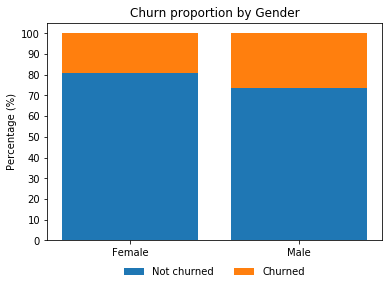

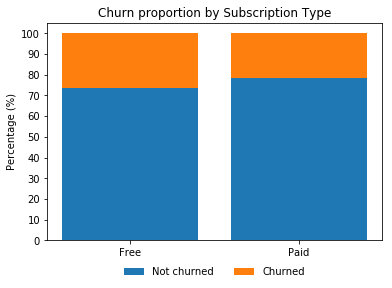

In [43]:
plot_churn_by_binary_feature(user_df_pd, 'gender', 'Gender', ['Female', 'Male'])
plot_churn_by_binary_feature(user_df_pd, 'lastSubscriptionLevel', 'Subscription Type', ['Free', 'Paid'])

In [44]:
def plot_churn_by_categorical_feature(df, feature_list, feature_name, feature_labels):
    s = user_df_pd.loc[:,'churned'].value_counts().div(user_df_pd.shape[0]/100)
    
    not_churned_values = [s[0]]
    churned_values = [s[1]]
    
    for feature in feature_list:
        total = len(user_df_pd[user_df_pd[feature] == 1])
        s = user_df_pd[user_df_pd[feature] == 1]['churned'].value_counts().div(total/100)
        
        not_churned_values.append(s[0])
        churned_values.append(s[1])
    
    feature_labels = ['Any'] + feature_labels
    
    fig, ax = plt.subplots()
    
    ax.bar(feature_labels, not_churned_values, label='Not churned')
    ax.bar(feature_labels, churned_values, bottom=not_churned_values, label='Churned')

    ax.set_ylabel('Percentage (%)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=5, frameon=False)
    ax.set_title('Churn proportion by ' + feature_name)
    
    plt.yticks(np.arange(0, 101, 10))

    plt.show()

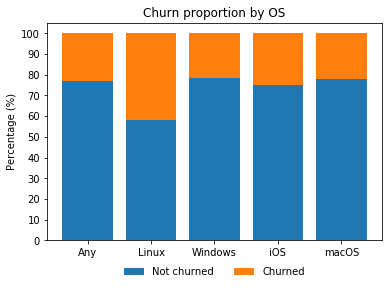

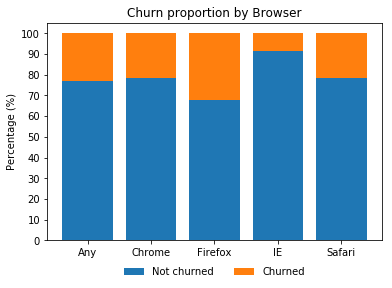

In [45]:
plot_churn_by_categorical_feature(user_df_pd,
                                  ['windows', 'macOS', 'iOS', 'linux'],
                                  'OS',
                                  ['Windows', 'macOS', 'iOS', 'Linux'])
plot_churn_by_categorical_feature(user_df_pd,
                                  ['firefox', 'chrome', 'safari', 'ie'],
                                  'Browser',
                                  ['Firefox', 'Chrome', 'Safari', 'IE'])

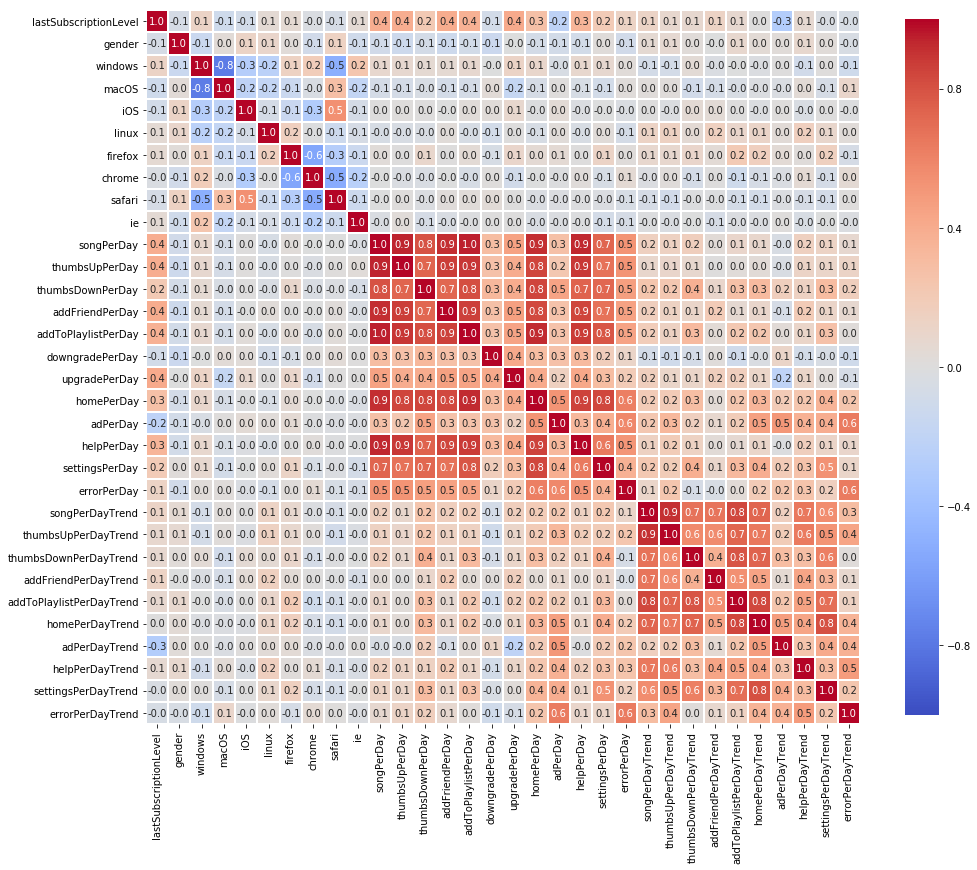

In [46]:
plt.figure(figsize=(16,16))
sns.heatmap(user_df_pd.drop(columns=['userId', 'churned']).corr(),
            cmap='coolwarm', annot=True, fmt='.1f', linewidths=1, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.show()

In [62]:
user_df = user_df.drop('lastSubscriptionLevel', 'gender', 'windows', 'macOS', 'iOS', 'chrome', 'safari', 'thumbsUpPerDay',
                       'thumbsDownPerDay', 'addFriendPerDay', 'addToPlaylistPerDay', 'homePerDay', 'helpPerDay',
                       'thumbsUpPerDayTrend', 'addToPlaylistPerDayTrend', 'homePerDayTrend')
user_df.columns

['userId',
 'churned',
 'linux',
 'firefox',
 'ie',
 'songPerDay',
 'downgradePerDay',
 'upgradePerDay',
 'adPerDay',
 'settingsPerDay',
 'errorPerDay',
 'songPerDayTrend',
 'thumbsDownPerDayTrend',
 'addFriendPerDayTrend',
 'adPerDayTrend',
 'helpPerDayTrend',
 'settingsPerDayTrend',
 'errorPerDayTrend']

In [63]:
categorical_features = ['linux',
                        'firefox',
                        'ie']
avg_features = ['songPerDay',
                'downgradePerDay',
                'upgradePerDay',
                'adPerDay',
                'settingsPerDay',
                'errorPerDay']
trend_features = ['songPerDayTrend',
                  'thumbsDownPerDayTrend',
                  'addFriendPerDayTrend',
                  'adPerDayTrend',
                  'helpPerDayTrend',
                  'settingsPerDayTrend',
                  'errorPerDayTrend']

In [64]:
len(user_df.columns) == len(categorical_features) + len(avg_features) + len(trend_features) + len(['userId', 'churned'])

True

In [65]:
avg_assembler = VectorAssembler(inputCols=avg_features, outputCol='avgVector')
trend_assembler = VectorAssembler(inputCols=trend_features, outputCol='trendVector')

avg_scaler = MinMaxScaler(inputCol='avgVector', outputCol='scaledAvgFeats')
trend_scaler = MaxAbsScaler(inputCol='trendVector', outputCol='scaledTrendFeats')

all_feats_assembler = VectorAssembler(inputCols=categorical_features + ['scaledAvgFeats', 'scaledTrendFeats'],
                                   outputCol='features')

# pipelines
pipeline_lr = Pipeline(stages = [avg_assembler,
                                 trend_assembler, 
                                 avg_scaler, 
                                 trend_scaler, 
                                 all_feats_assembler, 
                                 LogisticRegression(labelCol='churned')])
pipeline_rf = Pipeline(stages = [avg_assembler,
                                 trend_assembler, 
                                 avg_scaler, 
                                 trend_scaler, 
                                 all_feats_assembler,
                                 RandomForestClassifier(labelCol='churned')])
pipeline_gb = Pipeline(stages = [avg_assembler,
                                 trend_assembler, 
                                 avg_scaler, 
                                 trend_scaler, 
                                 all_feats_assembler,
                                 GBTClassifier(labelCol='churned')])

In [51]:
train, test = user_df.randomSplit([0.8, 0.2], seed = 37) 
user_df.count(), train.count(), test.count()

(225, 176, 49)

In [66]:
start = time.time()
model_lr = pipeline_lr.fit(train)
end = time.time()
print('Training took ' + time.strftime('%M:%S', time.gmtime(end-start)) + ' minutes')

Time spent for training: 5:28 minutes


In [67]:
start = time.time()
model_rf = pipeline_rf.fit(train)
end = time.time()
print('Training took ' + time.strftime('%M:%S', time.gmtime(end-start)) + ' minutes')

Time spent for training: 6:11 minutes


In [68]:
start = time.time()
model_gb = pipeline_gb.fit(train)
end = time.time()
print('Training took ' + time.strftime('%M:%S', time.gmtime(end-start)) + ' minutes')

Time spent for training: 8:45 minutes


In [69]:
results_lr = model_lr.transform(test)
results_rf = model_rf.transform(test)
results_gb = model_gb.transform(test)

In [70]:
evaluator = BinaryClassificationEvaluator().setLabelCol('churned')
evaluator.getMetricName()

'areaUnderROC'

In [ ]:
auc_lr = evaluator.evaluate(results_lr)
auc_rf = evaluator.evaluate(results_rf)
auc_gb = evaluator.evaluate(results_gb)

auc_lr, auc_rf, auc_gb

In [ ]:
evaluator = MulticlassClassificationEvaluator().setLabelCol('churned')
evaluator.getMetricName()

In [ ]:
f1_lr = evaluator.evaluate(results_lr)
f1_rf = evaluator.evaluate(results_rf)
f1_gb = evaluator.evaluate(results_gb)

f1_lr, f1_rf, f1_gb

In [ ]:
# Display feature importances
importances = model_rf.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_features + avg_features + trend_features
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

In [ ]:
# Display feature importances
importances = model_gb.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_features + avg_features + trend_features
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)